In [41]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import load_boston
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from numpy import random
from sklearn.model_selection import train_test_split
print("DONE")

DONE


In [42]:
boston_data=pd.DataFrame(load_boston().data,columns=load_boston().feature_names)
print(boston_data)
Y=load_boston().target
X=load_boston().data
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3)
print("X Shape: ",X.shape)
print("Y Shape: ",Y.shape)
print("X_Train Shape: ",x_train.shape)
print("X_Test Shape: ",x_test.shape)
print("Y_Train Shape: ",y_train.shape)
print("Y_Test Shape: ",y_test.shape)
# standardizing data
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test=scaler.transform(x_test)
## Adding the PRIZE Column in the data
train_data=pd.DataFrame(x_train)
train_data['price']=y_train
print(train_data.shape)
train_data.head(3)
x_test=np.array(x_test)
y_test=np.array(y_test)

        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  
0       15.3  396.90   4.98  
1       17.8  396.90   9.14  
2       1

In [17]:
#function to quantise gradients using deterministic rounding
def quantise_deterministic(X): 
   min_X=min(X)
   max_X=max(X)
   y=encode_deterministic(X,min_X,max_X)
   Y=decode_deterministic(y,min_X,max_X)
   return Y

def encode_deterministic(x,min_x,max_x):
    threshold=(min_x+max_x)/2
    y=np.zeros(len(x))
    for i in range(len(x)):
        if(x[i]>=threshold):
           y[i]=1
        else:
           y[i]=0
    return y

def decode_deterministic(x,min_X,max_X):
      threshold=(min_X+max_X)/2
      y=np.zeros(len(x))
      for i in range(len(x)):
        if(x[i]==0):
           y[i]=(threshold+min_X)/2
        else:
           y[i]=(threshold+max_X)/2
      return y

   

In [18]:
#function to quantise gradients using randomised rounding
def quantise_randomised(X): 
   min_X=min(X)
   max_X=max(X)
   X_shifted=X-min_X
   X_scaled=X_shifted/(max(X_shifted))
   y=encode_randomised(X_scaled)
   Y=decode_randomised(y,min_X,max_X)
   return Y

def encode_randomised(x):
    y=np.zeros(len(x))
    for i in range(len(x)):
        y[i]=np.random.binomial(n=1, p=x[i])
    return y

def decode_randomised(x,min_X,max_X):
      y=np.zeros(len(x))
      for i in range(len(x)):
           y[i]=x[i]
      Y=(y*(max_X-min_X))+min_X
      return Y




In [38]:
def MyCustomSGD(train_data,learning_rate,n_iter,k,divideby):
    
    # Initially we will keep our W and B as 0 as per the Training Data
    w=np.zeros((1,train_data.shape[1]-1))
    b=0
    
    cur_iter=1
    while(cur_iter<=n_iter): 

        # We will create a small training data set of size K
        temp=train_data.sample(k)
        # We create our X and Y from the above temp dataset
        y=np.array(temp['price'])
        x=np.array(temp.drop('price',axis=1))
        
        # We keep our initial gradients as 0
        w_gradient=np.zeros(shape=(1,train_data.shape[1]-1))
        b_gradient=0
        
        for i in range(k): # Calculating gradients for point in our K sized dataset
            prediction=np.dot(w,x[i])+b
            cur_w_grad=(-2)*x[i]*(y[i]-(prediction)) #actual gradients w.r.t w
            cur_b_grad=(-2)*(y[i]-(prediction))   #actual gradient w.r.t b
            cur_grad=np.concatenate((cur_w_grad,cur_b_grad)) #getting single vector containing all gradients
            cur_quant_grad=quantise_randomised(cur_grad) #quantising gradient vector using randomised rounding 
            #In the above line,we call 'quantise_deterministic' function to quantise gradients using deterministic rounding

            cur_w_grad_quantised=cur_quant_grad[:-1]
            cur_b_grad_quantised=cur_quant_grad[-1]
            w_gradient=w_gradient+(cur_w_grad_quantised)   # using quantised gradients while aggregating
            b_gradient=b_gradient+(cur_b_grad_quantised)
            

        
        #Updating the weights(W) and Bias(b) with the above calculated Gradients
        w=w-learning_rate*(w_gradient/k)
        b=b-learning_rate*(b_gradient/k)
        
        # Incrementing the iteration value
        cur_iter=cur_iter+1
        
        
        #Dividing the learning rate by the specified value
        learning_rate=learning_rate/divideby

    
    return w,b #Returning the weights and Bias

In [39]:
def predict(x,w,b):
    y_pred=[]
    for i in range(len(x)):
        y=np.asscalar(np.dot(w,x[i])+b)
        y_pred.append(y)
    return np.array(y_pred)
    

w,b= [[-0.52783073  0.21369956 -1.05370772  1.40394157 -0.38661626  2.72192596
  -0.26448444 -1.20968484  0.35740504 -0.12629196 -1.55695061  0.77614474
  -3.112339  ]] 19.7605366299281
Predicted y: [20.21448343 12.76622403 10.60143945 21.65905784 15.67021101 20.24467512
 23.03557905 16.56938451 15.34152324 27.19701148 26.743633    8.00927803
 28.03633351 16.37562913 35.38087492 10.36611623 30.99292129  9.79983005
 21.53260058 18.30568462  3.67591135 24.01900613 24.73638108 28.57267089
 15.57731794 13.98379777 18.60222824  6.12746356 31.27525155 27.03339668
 19.51806094  4.1623025  28.56060979 14.67895951 18.4378438  15.71130669
 10.15467782 30.55060884 15.19353739 29.62341553 27.23971368  1.31822986
 16.98047544 11.07968603 19.16205795 21.54474508 18.83098394 27.54514596
 20.53844905 11.12100205 19.78927076 27.93195209 14.65511957 22.06690569
 16.18193476 19.03145842 24.30478425 21.67251175 17.85091678 22.5563669
 13.98455702 30.78141371 23.33516503  7.14460498 19.15835419 12.78892944

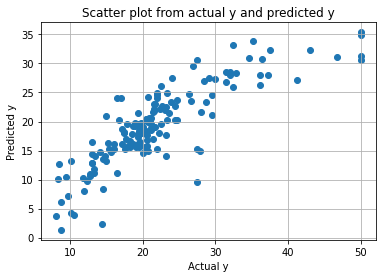

Mean Squared Error : 28.04760835954109


In [40]:
w,b=MyCustomSGD(train_data,learning_rate=0.001,n_iter=1000,divideby=1,k=10)
print("w,b=",w,b)
y_pred_customsgd=predict(x_test,w,b)
print("Predicted y:",y_pred_customsgd)
print("Actual y:",y_test)
plt.scatter(y_test,y_pred_customsgd)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter plot from actual y and predicted y')
plt.show()
print('Mean Squared Error :',mean_squared_error(y_test, y_pred_customsgd))